In [8]:
import sys

sys.path.append("../src/preprocessing")

from utils import load_eeg
import mne
from joblib import Parallel, delayed
from tqdm import trange
import numpy as np
from antropy import lziv_complexity
from functools import partial
import matplotlib.pyplot as plt
import neurokit2 as nk
import pandas as pd

In [20]:
def compute_hrv(ecg, sfreq):
    """
    Compute Heart Rate Variability (HRV) from the ECG channel using NeuroKit2.

    Steps:
    1. Clean the raw ECG signal.
    2. Detect R-peaks.
    3. Compute RR-intervals in milliseconds.
    4. Calculate time-domain HRV features (SDNN, RMSSD, pNN50, etc.).

    Parameters:
    -----------
    raw : mne.io.Raw
        Raw EEG data containing an "ECG" channel.
    sfreq : float
        Sampling frequency of the signal in Hz.

    Returns:
    --------
    hrv_features : pandas.DataFrame
        One‐row DataFrame of time-domain HRV metrics (e.g., SDNN, RMSSD, pNN50).
    """
    # 1) Extract & clean ECG
    assert ecg.shape[0] == 1, "Only one ECG channel is supported."
    ecg_clean = nk.ecg_clean(ecg[0], sampling_rate=sfreq)

    # 2) Detect R-peaks
    peaks, info = nk.ecg_peaks(ecg_clean, sampling_rate=sfreq)
    rpeaks = info["ECG_R_Peaks"]

    # 3) Compute RR-intervals (ms)
    rr_intervals = np.diff(rpeaks) / sfreq * 1000  # now in ms

    # 4) Wrap intervals in a DataFrame so hrv_time knows they're RRI
    df_rri = pd.DataFrame({"RRI": rr_intervals})

    hrv_features = nk.hrv_time(df_rri, sampling_rate=sfreq)
    hrv_freq = nk.hrv_frequency(peaks, sfreq)
    hrv_nonlinear = nk.hrv_nonlinear(peaks, sfreq)

    return hrv_features, hrv_freq, hrv_nonlinear

In [15]:
def sliding_window(raw, func, window_seconds, step_seconds, include_chans=[], exclude_chans=[], n_jobs=-1):
    raw = raw.copy()
    # Select channels to include or exclude
    if include_chans:
        raw.pick_channels(include_chans)
    elif exclude_chans:
        raw.drop_channels(exclude_chans)

    data = raw.get_data()
    sfreq = raw.info["sfreq"]
    window = int(window_seconds * sfreq)
    step = int(step_seconds * sfreq)
    results = Parallel(n_jobs=n_jobs)(
        delayed(func)(data[:, i : i + window], sfreq) for i in trange(0, data.shape[1] - window, step)
    )
    times = np.arange(0, len(data[0]) - window, step) / sfreq
    return times, results


def lzc(x, sfreq, normalize=True, axis=-1):
    x = x > np.median(x, axis=axis, keepdims=True)
    return np.apply_along_axis(lziv_complexity, axis, x, normalize=normalize)


def psd(x, sfreq, fmin, fmax, precision_hz, relative=True, axis=-1):
    """
    Compute the power spectral density of the signal using Welch's method.

    Parameters:
    -----------
    x : array-like
        The input signal
    sfreq : float
        Sampling frequency of the signal in Hz
    fmin : float
        Minimum frequency of interest in Hz
    fmax : float
        Maximum frequency of interest in Hz
    precision_hz : float
        Size of each frequency bin in Hz
    axis : int
        Axis along which to compute the PSD

    Returns:
    --------
    array-like
        The average power spectral density across the specified frequency range
    """
    # Calculate n_fft from the desired frequency precision (bin size)
    # The relation is: precision_hz = sfreq / n_fft
    n_fft = int(np.ceil(sfreq / precision_hz))
    # Compute PSD using Welch's method for the entire frequency range (0.5-50 Hz)
    Pxx_all, freqs_all = mne.time_frequency.psd_array_welch(x, sfreq, n_fft=n_fft, average="mean", verbose=False)

    # Create mask for the frequency band of interest
    freq_mask = (freqs_all >= fmin) & (freqs_all <= fmax)

    # Extract the PSD values for the frequency band of interest
    Pxx = Pxx_all[:, freq_mask]

    # If relative is True, normalize by the total power
    if relative:
        total_power = Pxx_all.sum(axis=-1, keepdims=True)
        Pxx = Pxx / total_power

    # Calculate the mean power across the specified frequency band
    return Pxx.mean(axis=axis)

In [3]:
freq_bands = {
    "delta": (0.5, 4.0),
    "theta": (4.0, 8.0),
    "alpha": (8.0, 12.0),
    "beta": (12.0, 30.0),
    "gamma": (30.0, 45.0),
}

In [12]:
subjs = {"curandero": "01", "patient": "03"}
for name, subj in subjs.items():
    subjs[name] = load_eeg(subj, "ceremony1", "../data/003_sanitization", preload=True)
    subjs[name] = subjs[name].pick_types(eeg=True, exclude=["CM", "A1", "A2"])

Extracting EDF parameters from c:\Users\pthoe\projects\mexico\mushroom_hyperscanning\data\003_sanitization\sub-01\ses-ceremony1\eeg\sub-01_ses-ceremony1_task-psilo_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5612999  =      0.000 ... 18709.997 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from c:\Users\pthoe\projects\mexico\mushroom_hyperscanning\data\003_sanitization\sub-03\ses-ceremony1\eeg\sub-03_ses-ceremony1_task-psilo_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5106599  =      0.000 ... 17021.997 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


In [16]:
cur = subjs["curandero"].copy()

In [ ]:
times, results = {}, {}
for feat in freq_bands:
    fmin, fmax = freq_bands[feat]
    t, p = sliding_window(
        cur, partial(psd, fmin=fmin, fmax=fmax, precision_hz=2), 60 * 2, 60, exclude_chans=["ECG"], n_jobs=-1
    )
    times[feat] = t
    results[feat] = np.array(p)

t, lz = sliding_window(cur, lzc, 60 * 2, 60, exclude_chans=["ECG"], n_jobs=-1)
times["lzc"] = t
results["lzc"] = np.array(lz).T

t, hrv = sliding_window(cur, compute_hrv, 60 * 2, 60, include_chans=["ECG"], n_jobs=-1)
times["hrv_lf"] = t
results["hrv_lf"] = np.array([h[1]["HRV_LF"].values for h in hrv])
times["hrv_hf"] = t
results["hrv_hf"] = np.array([h[1]["HRV_HF"].values for h in hrv])





















100%|██████████| 310/310 [00:05<00:00, 57.57it/s]


In [6]:
cur.annotations.to_data_frame()["description"].unique()

array(['head movement', 'eye blinks', 'jaw clench', 'eyes open',
       'eyes closed', 'interruption, curandero bathroom', 'start control',
       '5', 'ingestion', 'resynchronize EEG',
       'interruption, curandero standing', '7', 'limpia',
       'interruption, second apprentice enters',
       'patient wakes up from trance', 'patient speaking',
       'catarsis, patient',
       'interruption, curandero mastoid electrode adjustment',
       'interruption, curandero crying', 'interruption, curandero vomits',
       'catarsis, curandero leaves trance', 'catarsis, patient thanking',
       'limpia, apprentice', 'interruption, general break'], dtype=object)

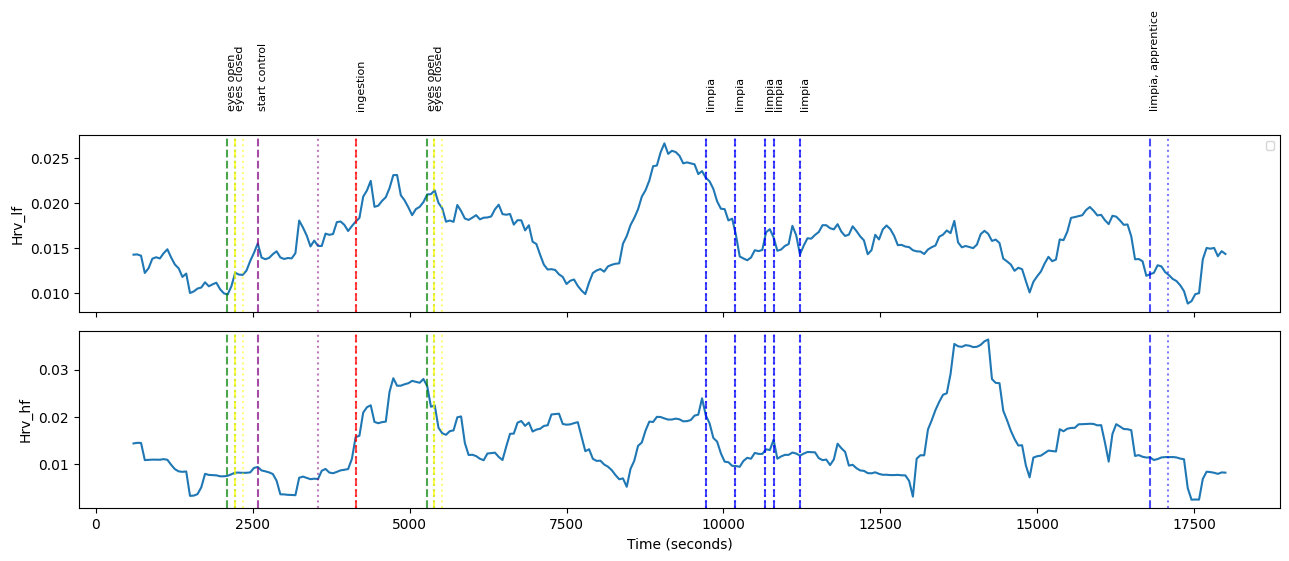

In [63]:
def smooth(x, window=20):
    return pd.Series(x).rolling(window=window, center=True).mean().values


include_triggers = {
    "start control": "purple",
    "ingestion": "red",
    "limpia": "blue",
    "eyes open": "green",
    "eyes closed": "yellow",
}

# Create a figure with subplots for each frequency band
fig, axes = plt.subplots(len(results), 1, figsize=(13, 3 * len(results)), sharex=True)

# Plot each frequency band
for i, feat in enumerate(results.keys()):
    ax = axes[i]
    ax.plot(times[feat], smooth(results[feat].mean(axis=1)))
    ax.set_ylabel(feat.capitalize())

# Set common x-axis label
axes[-1].set_xlabel("Time (seconds)")

# Add vertical lines for triggers from annotations
for i, feat in enumerate(results.keys()):
    ax = axes[i]
    # Get all annotations from the EEG data
    for idx, annotation in enumerate(cur.annotations):
        desc = annotation["description"]
        onset = annotation["onset"]
        duration = annotation["duration"]
        # Check if the annotation description starts with any of the included triggers
        if any(desc.startswith(trigger) for trigger in include_triggers.keys()):
            # Find which trigger matches to get the correct color
            for trigger, color in include_triggers.items():
                if desc.startswith(trigger):
                    # Add vertical line at the onset with the trigger-specific color
                    ax.axvline(x=onset, color=color, linestyle="--", alpha=0.7, label=desc if idx == 0 else "")

                    # Add vertical line at the end of the annotation (onset + duration)
                    ax.axvline(x=onset + duration, color=color, linestyle=":", alpha=0.5)

                    # Add text annotation for the first band only to avoid clutter
                    if i == 0:
                        ax.text(
                            onset,
                            ax.get_ylim()[1] + (ax.get_ylim()[1] * 0.1),
                            desc,
                            rotation=90,
                            fontsize=8,
                            verticalalignment="bottom",
                        )
                    break  # Break once we've found the matching trigger

# Add a legend for the first subplot only
handles, labels = axes[0].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
axes[0].legend(by_label.values(), by_label.keys(), loc="upper right", fontsize=8)

# Adjust spacing between subplots
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the suptitle
plt.show()